# 语言模型

给一个语言模型 作用

预训练模型
生成文本
判断文本合理


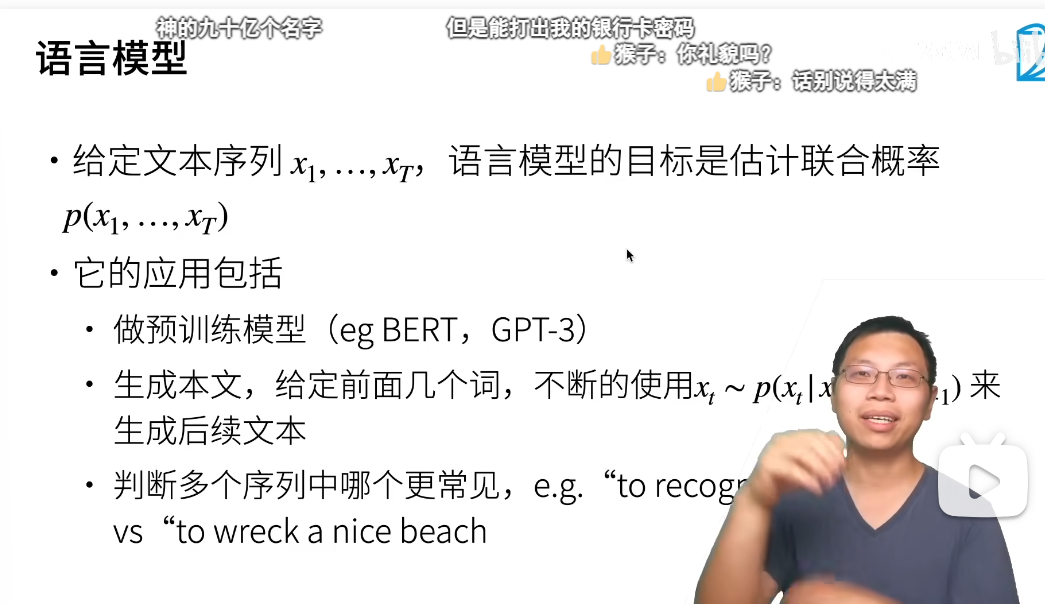

# 语言模型的建模

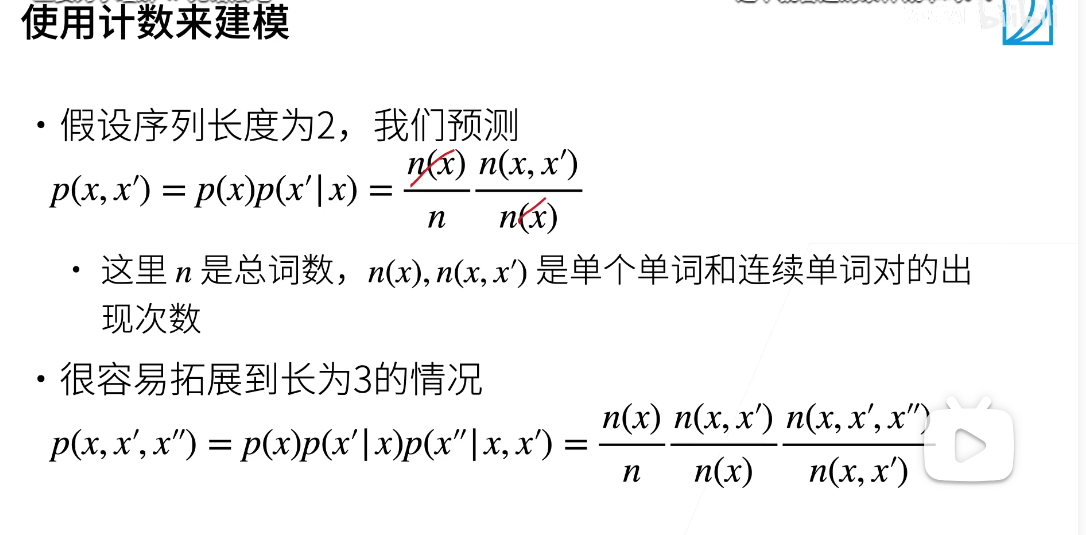

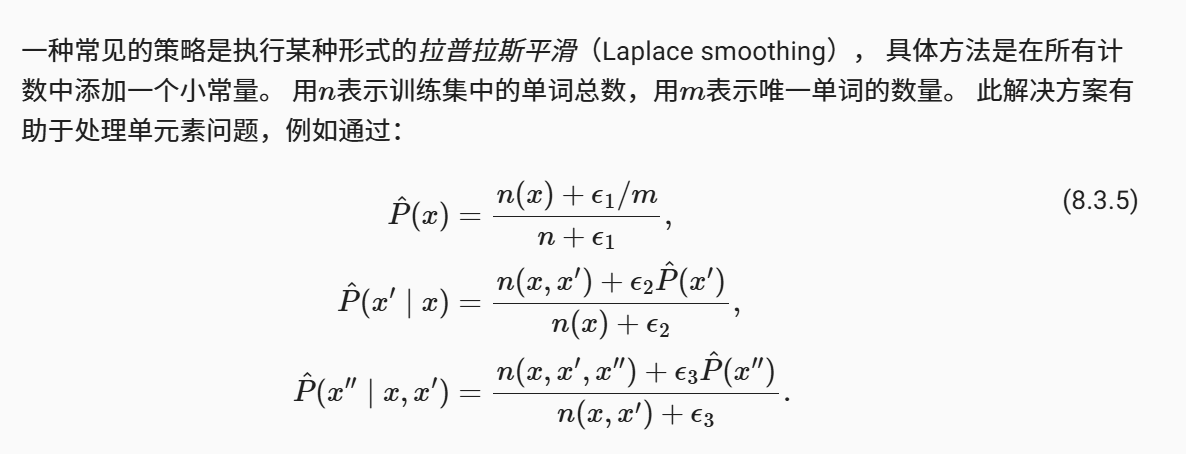

# 如果序列很长 因为文本量不够大（使用马尔可夫假设）

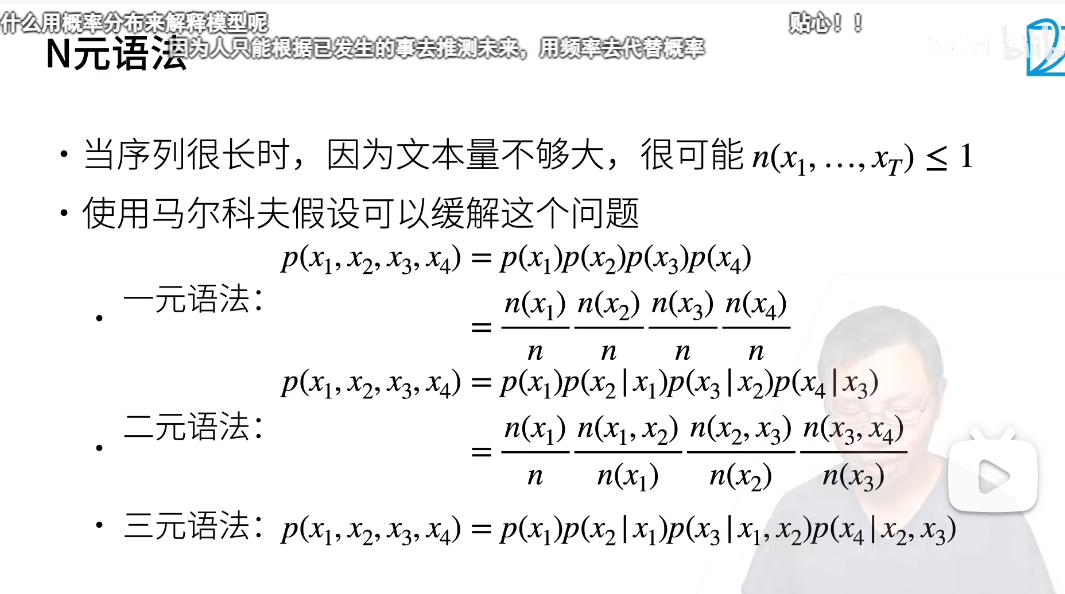

最大的好处即可以处理长序列

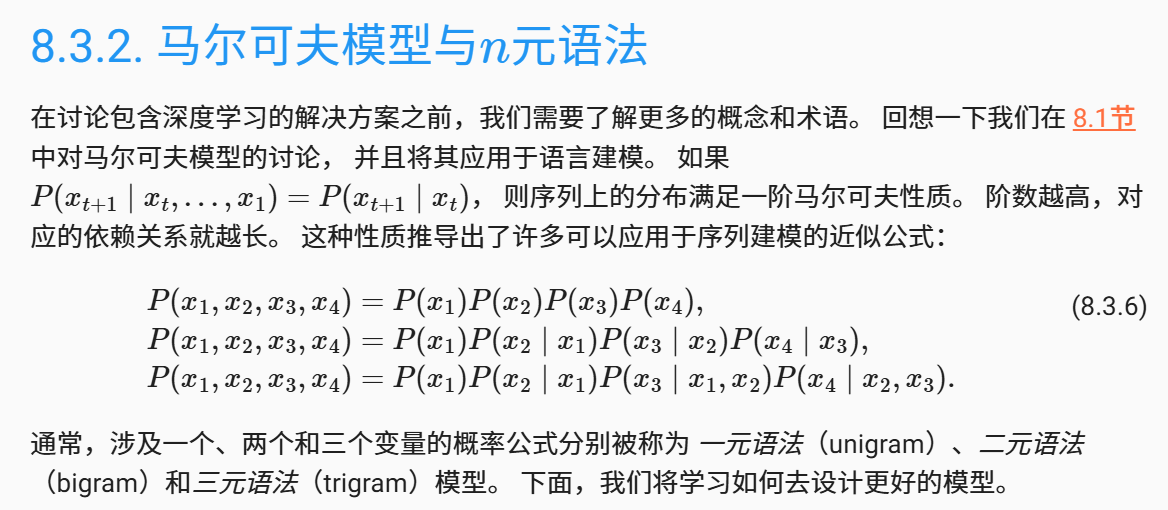

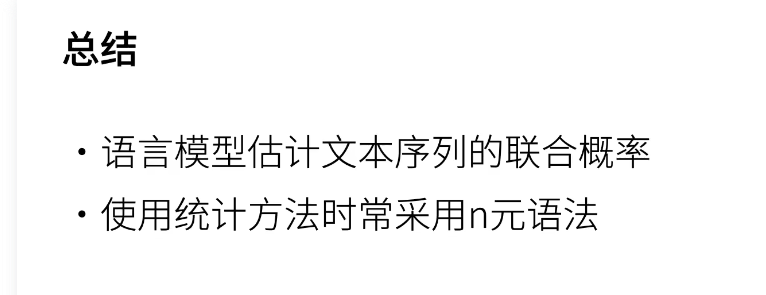

In [6]:
import random
import torch
from d2l import torch as d2l

# 读取时间机器中的文本并进行词元化
tokens = d2l.tokenize(d2l.read_time_machine())
# 将所有文本行的词元拼接到一起，形成一个大列表
corpus = [token for line in tokens for token in line]

# 创建词表，使用 corpus 中的词元
vocab = d2l.Vocab(corpus)

# 输出词表中前 10 个词元及其频率

# stopwords 停用词大量出现 但对文本理解作用不大
vocab.token_freqs[:20]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243),
 ('for', 221),
 ('with', 216),
 ('but', 204),
 ('time', 200),
 ('were', 158)]

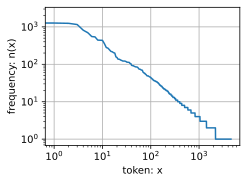

In [7]:
# 画出词频图

freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

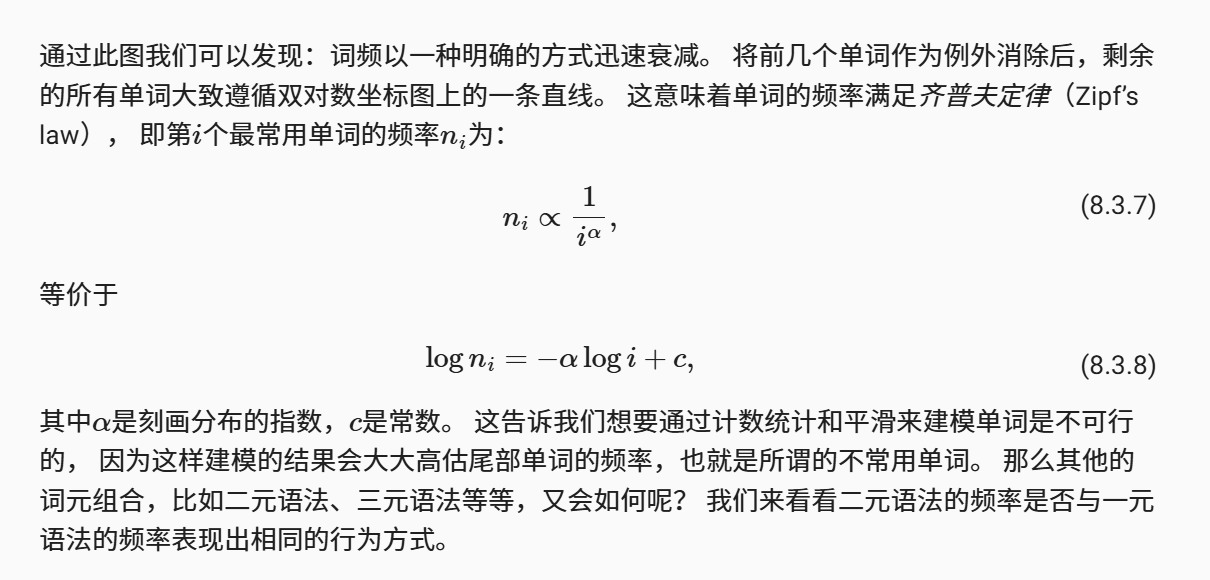

In [8]:
# 探讨其他词元组合 比如二元语法和三元语法


# 使用 zip 函数创建大ram（二元组）词元
# bigram_tokens 包含相邻的词元对，形成一个列表
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
# 这里，corpus[:-1] 代表去掉最后一个词元的列表，corpus[1:] 代表去掉第一个词元的列表
# zip 函数将这两个列表中的元素配对，形成二元组

# 使用大ram词元创建词表
bigram_vocab = d2l.Vocab(bigram_tokens)

# 输出二元组词表中前 10 个词元及其频率
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [13]:
# 三元词（更好反映文章原意）

# 使用 zip 函数创建三元组（trigram）词元
# trigram_tokens 包含相邻的三个词元配对，形成一个列表
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
# 在这个列表推导式中，除了第一个和最后两个词元以外
# corpus[:-2] 代表去掉最后两个元素的列表
# corpus[1:-1] 代表去掉第一个和最后一个元素的列表
# corpus[2:] 代表去掉前两个元素的列表
# zip 函数将这三个列表中的元素配对，形成三元组

# 使用三元组词元创建词表
trigram_vocab = d2l.Vocab(trigram_tokens)

# 输出三元组词表中前 10 个词元及其频率
trigram_vocab.token_freqs[:10]


[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

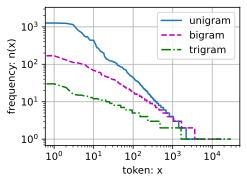

In [11]:
# 将三种词语频率进行对比
# 一元语法、二元语法和三元语法
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

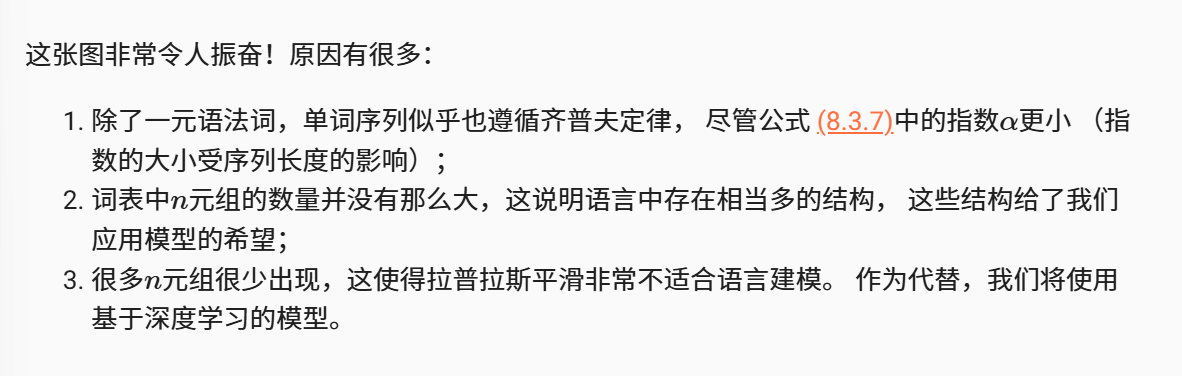

当序列变得太长而不能被模型一次性全部处理时， 
我们可能希望拆分这样的序列方便模型读取。

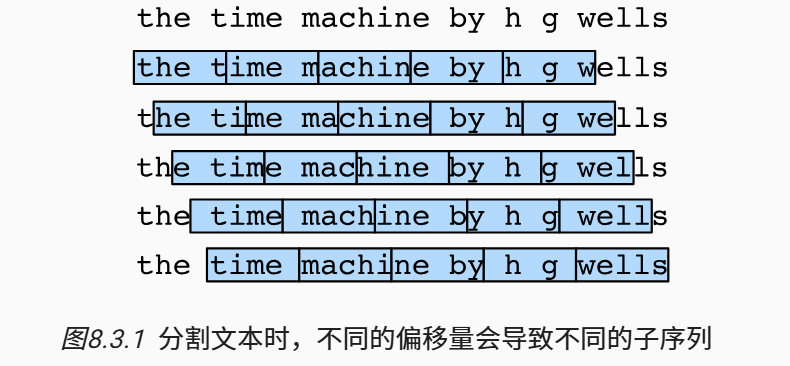

 事实上，他们都一样的好。 然而，如果我们只选择一个偏移量， 那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的。 因此，我们可以从随机偏移量开始划分序列， 以同时获得覆盖性（coverage）和随机性（randomness）。 下面，我们将描述如何实现随机采样（random sampling）和 顺序分区（sequential partitioning）策略。

In [15]:
# 随机生成一个小批量数据的特征和标签以供读取

# 每个样本都是在原始的长序列上任意捕获的子序列

# 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻

# 目标是基于到目前为止我们看到的词元来预测下一个词元， 
# 因此标签是移位了一个词元的原始序列


# 在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列


def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # corpus（文本序列）、batch_size（每个批次的大小）和 num_steps（每个子序列的长度)
    
    # 从随机偏移量开始对序列进行分区，随机范围包括 num_steps - 1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 计算可以创建的子序列的数量，减去 1 是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    
    # 计算每个长度为 num_steps 的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    
    # 在随机抽样的过程中，两个相邻的、随机的小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从 pos 位置开始的长度为 num_steps 的序列
        return corpus[pos: pos + num_steps]

    # 计算每个批量可以生成的批次数
    num_batches = num_subseqs // batch_size
    
    # 生成批量数据
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices 包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        # 生成输入序列 X 和标签 Y
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        # 返回输入序列 X 和标签 Y，转换为张量
        yield torch.tensor(X), torch.tensor(Y)

In [39]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [23, 24, 25, 26, 27]])
X:  tensor([[12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22]])


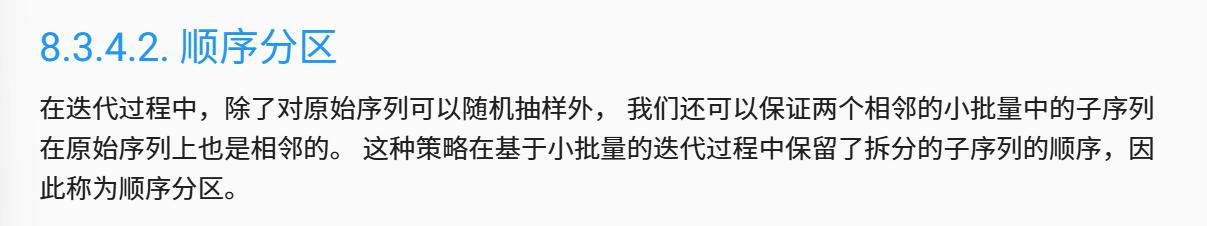

In [31]:
# 保证两个相邻的小批量中的子序列在原始序列上也是相邻的

# corpus（文本序列）、batch_size（每个批次的大小）和 num_steps（每个子序列的长度）


def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)  # 随机生成一个偏移量，保证不会超出序列范围
    
    # 计算可以用于批量的标记数量
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    # 从偏移量开始截取 corpus 且确保能够被 batch_size 整除的数量
    Xs = torch.tensor(corpus[offset: offset + num_tokens])  # 创建输入序列的张量
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])  # 创建标签序列的张量，标签是输入序列向后移动一位
    
    # 将 Xs 和 Ys 重塑为 (batch_size, -1) 的形状，-1 意味着自动计算列数
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    
    # 计算可以生成的批次数
    num_batches = Xs.shape[1] // num_steps  # 获取每个批次中的数据量
    
    # 生成批量数据
    for i in range(0, num_steps * num_batches, num_steps):
        # 提取当前批次的输入和标签
        X = Xs[:, i: i + num_steps]  # 获取当前批次的输入序列
        Y = Ys[:, i: i + num_steps]  # 获取当前批次的标签序列
        yield X, Y  # 使用 yield 返回当前批次的输入和标签

In [38]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [37]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [34]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

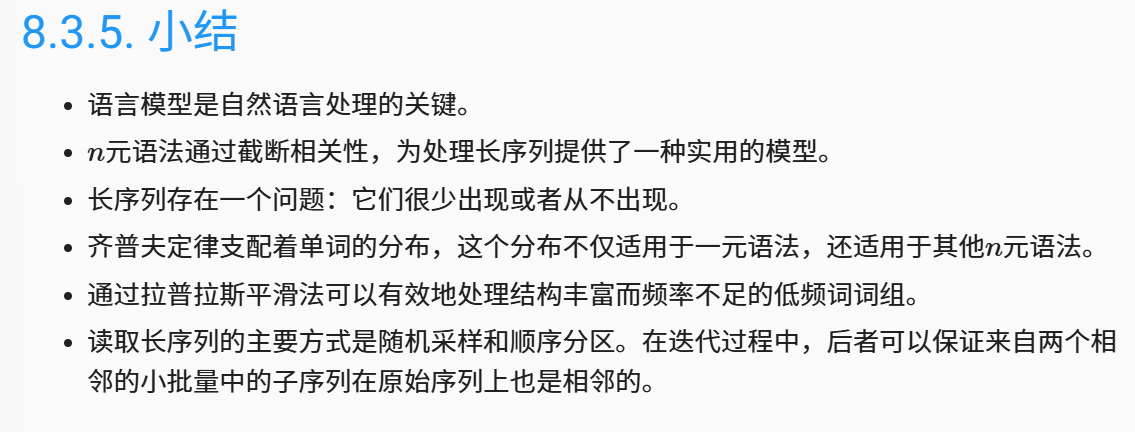